<a href="https://colab.research.google.com/github/Esther-Opeyemi/Activity1/blob/master/Stage_E_Ass_Time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Time Series Libraries
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA

!pip install pystan~=2.14
!pip install fbprophet
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 118 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 599 kB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6638571 sha256=510ff3c0111ef0edfec943a09cc581e1bc272d42a7406271fbcecf059b4acd13
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.7
    Uninstalling cmdstanpy-1.0.7:
      Successfully uninstalled cmdstanpy-1.0.7
ERROR: pip's dependency resolver does not currently take into account all the 

In [25]:
#Read/load dataset
householdP_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip', sep=';', header=0, low_memory=False,
                 infer_datetime_format=True, parse_dates={'datetime': [0, 1]}, index_col=['datetime'])

In [27]:
print(householdP_data.shape)
householdP_data.head()

(2075259, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [29]:
#check for missing data
householdP_data.isnull().values.sum()

25979

In [31]:
# Linear forward interpolation to fill missing values
householdP_data = householdP_data.interpolate(method='linear', limit_direction='forward')
householdP_data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [32]:
householdP_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [36]:
#mk a copy without altration 
householdP_data_copy = householdP_data.copy()

In [37]:
# check for null values in copied dataset
householdP_data_copy.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [39]:
#CONVERSION: columns to float types
cols = householdP_data_copy.columns
householdP_data_copy[cols] = householdP_data_copy[cols].apply(pd.to_numeric, errors='coerce')

In [57]:
# Calculate and Add active energy consumed every minutes
householdP_data_copy['Energy_Consumed_Per_Min'] = ((householdP_data_copy['Global_active_power'] * 1000)/60 -
                                      householdP_data_copy['Sub_metering_1'] - householdP_data_copy['Sub_metering_2'] - householdP_data_copy['Sub_metering_3'])
householdP_data_copy.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Energy_Consumed_Per_Min
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [58]:
# Create Time Series with Global active power
householdP_data_copy1 = householdP_data_copy.drop(columns=['Energy_Consumed_Per_Min', 'Global_reactive_power', 'Voltage',
                                 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'], axis=1)

In [59]:
# Filling missing values by linear forward interpolation
householdP_data_copy1 = householdP_data_copy1.interpolate(method='linear', limit_direction='forward')
householdP_data_copy1.isnull().sum()

Global_active_power    0
dtype: int64

In [60]:
# create  and preview  time series for Global active power per minutes
householdP_data2 = householdP_data_copy1[['Global_active_power']]
householdP_data2.head()

,Global_active_power
datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


Text(0, 0.5, 'Global Active Power')

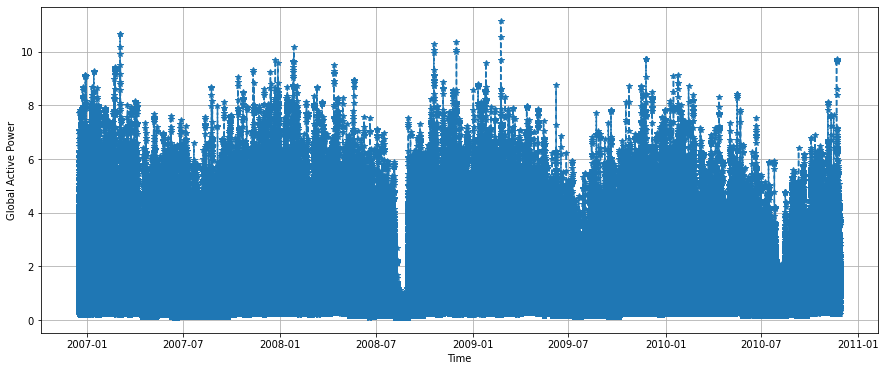

In [61]:
#Check Global_active_power plot
plt.figure(figsize=(15, 6))
plt.plot(householdP_data2.index, householdP_data2.Global_active_power, '--', marker='*', )
plt.grid()
plt.xlabel('Time')
plt.ylabel('Global Active Power')

In [62]:
#Sample Global Active Power from minutes to daily data points
householdP_data_daily = householdP_data2.resample('D').mean()

Text(0, 0.5, 'Global Active Power')

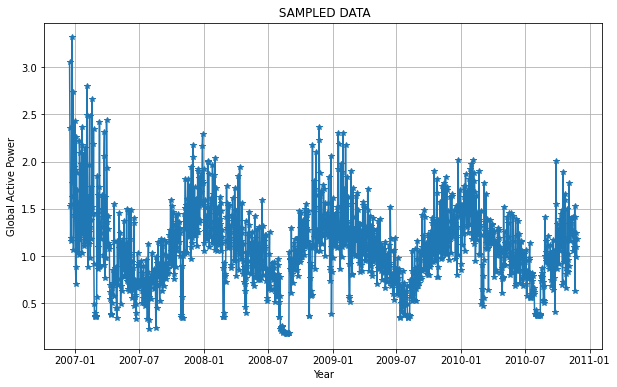

In [63]:
# preview downsampling 
plt.figure(figsize=(10, 6))
plt.plot(householdP_data_daily, marker='*')
plt.grid()
plt.title(' SAMPLED DATA')
plt.xlabel('Year')
plt.ylabel('Global Active Power')

Text(0, 0.5, 'Global active power')

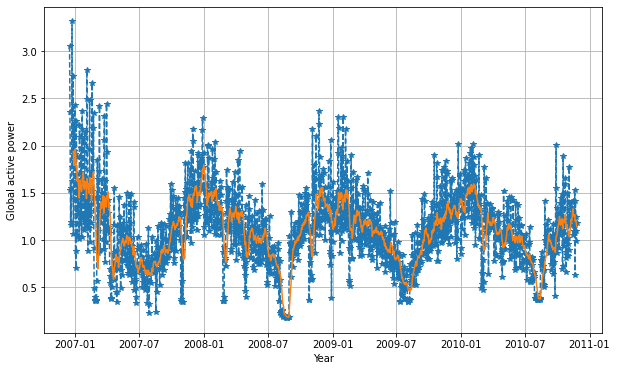

In [64]:
# Moving Average Smoothing additon
householdP_data_MA = householdP_data_daily.copy()
MA = householdP_data_MA[ 'Global_active_power' ].rolling( 12 ).mean()

# Preview MAP (Moving Average plot)
plt.figure(figsize=(10, 6))
plt.plot(householdP_data_MA.index, householdP_data_MA.Global_active_power, '--', marker='*', )
plt.plot(MA)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Global active power')

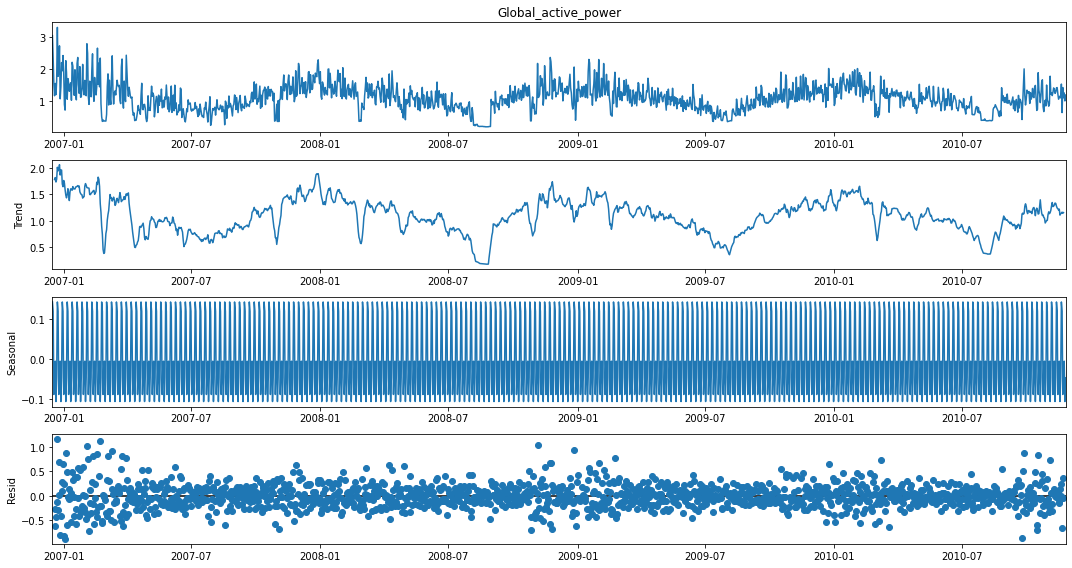

In [65]:
#summary plot of seasonal_decompose statistical
rcParams[ 'figure.figsize' ] = 15 , 8
decompose_series = sm.tsa.seasonal_decompose(householdP_data_daily[ 'Global_active_power' ], model= 'additive')
decompose_series.plot()
plt.show()

STATIONARITY

In [70]:
# Using Auto - Dick Fuller to determine the trend and seasonality variations.

adf_result = adfuller(householdP_data_daily['Global_active_power'])
print(f'ADF Statistic: {adf_result[ 0 ]} ')
print(f'p-value: {adf_result[ 1 ]} ')
print(f'No. of lags used: {adf_result[ 2 ]} ')
print(f'No. of observations used : {adf_result[ 3 ]} ')
print('Critical Values:')
for k, v in adf_result[4].items():
    print(f' {k} : {v} ')

ADF Statistic: -3.6867338256811175 
p-value: 0.004303671878000958 
No. of lags used: 22 
No. of observations used : 1419 
Critical Values:
 1% : -3.434966750462565 
 5% : -2.8635789736973725 
 10% : -2.5678555388041384 


TRAIN MODELS

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


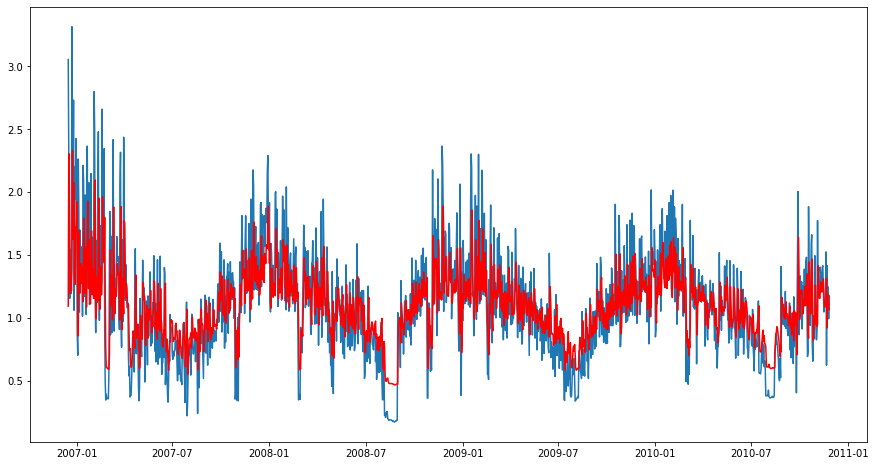

In [72]:
# AR MODEL deployed
AR_model = ARIMA(householdP_data_daily, order=(2,0,0))
AR_model_results = AR_model.fit()
plt.plot(householdP_data_daily)
plt.plot(AR_model_results.fittedvalues, color='red')
plt.show()

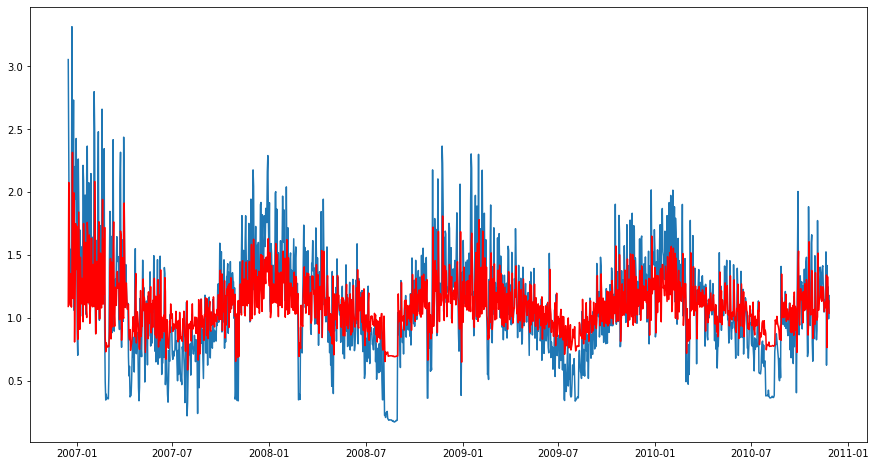

In [73]:
# USING MA MODEL
AR_model = ARIMA(householdP_data_daily, order=(0,0,2))
AR_model_results = AR_model.fit()
plt.plot(householdP_data_daily)
plt.plot(AR_model_results.fittedvalues, color='red')
plt.show()

Training and Testing Set

In [74]:
# Downsample to daily data points
householdP_data_daily1 = householdP_data2.resample('D').mean()
householdP_data_daily1 = householdP_data_daily1.reset_index()
householdP_data_daily1 = householdP_data_daily1.rename(columns={ "datetime" : "ds" , "Global_active_power" : "y" })
householdP_data_daily1

,ds,y
0,2006-12-16,3.053475
1,2006-12-17,2.354486
2,2006-12-18,1.530435
3,2006-12-19,1.157079
4,2006-12-20,1.545658
...,...,...
1437,2010-11-22,1.417733
1438,2010-11-23,1.095511
1439,2010-11-24,1.247394
1440,2010-11-25,0.993864


In [76]:
train_end = 1442 - 365

train_data = householdP_data_daily1.iloc[:train_end]
test_data = householdP_data_daily1.iloc[train_end:]

PROPHET Model

In [79]:
model = Prophet()
model_fit = model.fit(train_data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ARMA(4,1) mode

In [82]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

#get the predictions and residuals
preds = model_fit.predict(test_data)
residuals = test_data - preds

In [83]:
preds = preds[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
metric = preds.set_index('ds')[['yhat']].join(test_data.set_index('ds').y).reset_index()
sqrt(mean_absolute_error(metric.y, metric.yhat))

0.4483888459682902

In [84]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(metric.y, metric.yhat)

21.361457827640276

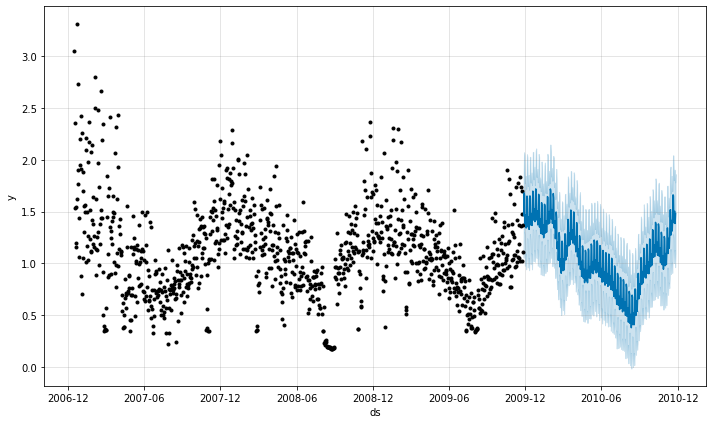

In [85]:
model.plot(preds)
plt.show()